## LFP Analysis

In [ ]:
# Imports and setup
# Allow jupyter notebook to reload modules

#%load_ext autoreload
from __future__ import annotations

import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from fooof import FOOOF

from spk2extract.logs import logger
from spk2extract.extraction.oscillations import LfpSignal, get_data

# Setup functions, classes and styles
logger.setLevel("INFO")
sns.set_style("darkgrid")

data_path = Path().home() / "data" / "extracted"
file = list(data_path.glob("*0609*.h5"))[0]
df_s, df_t, events, event_times = get_data(file)
unique_events = np.unique(events)
key = {
    "0": "dug incorrectly",
    "1": "dug correctly",
    "x": "crossed over (no context)",
    "b": "crossed over into the black room",
    "w": "crossed over into the white room",
}
fs = 2000
lfp = LfpSignal(df_s, df_t, event_arr=events, ev_times_arr=event_times, fs=2000, filename=file)

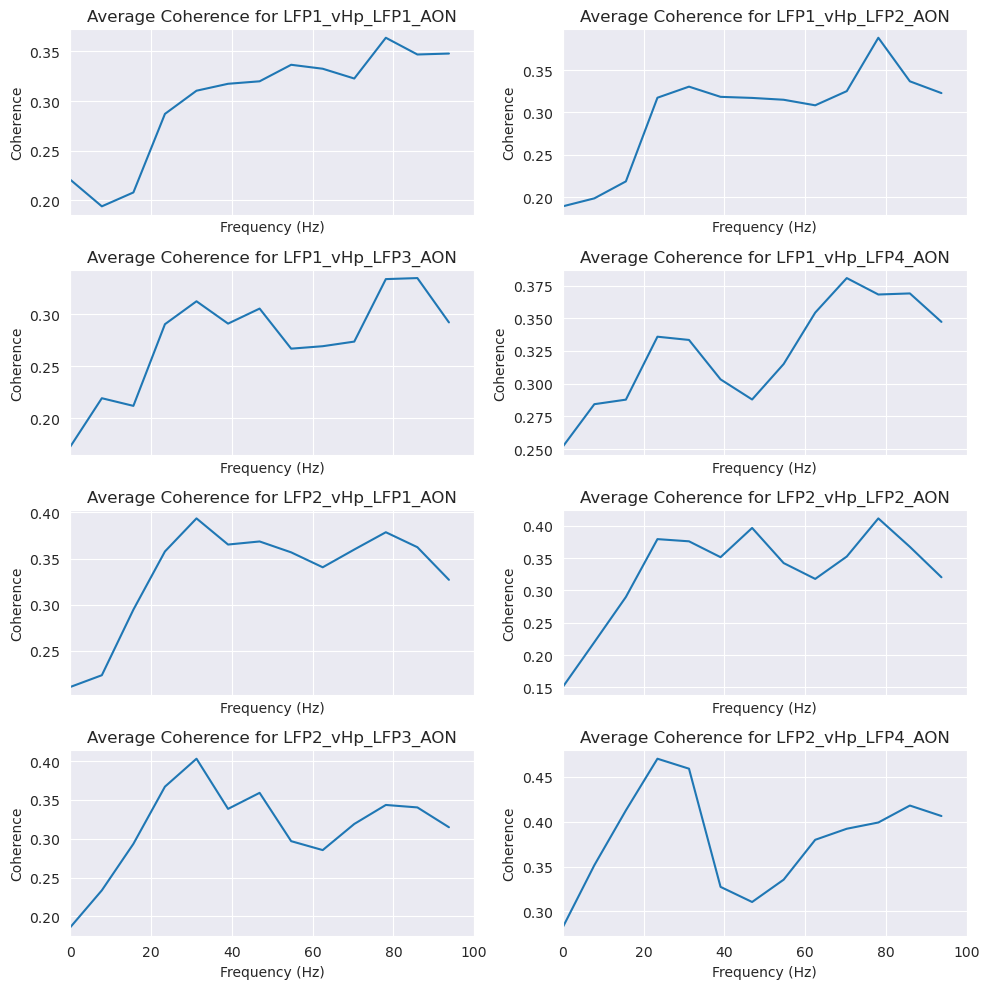

In [16]:
from scipy.signal import coherence

# Get spikes for each event
spikes = lfp.spikes
aon_cols = [col for col in spikes.columns if 'AON' in col]

df_aon = spikes[[col for col in spikes.columns if 'vHp' in col]]
df_vhp = spikes[[col for col in spikes.columns if 'AON' in col]]

coherence_sums = {}
coherence_counts = {}
windows = lfp.get_windows(1)

for window in windows['b_1']:
    start_idx = int(window[0] * fs)
    end_idx = int(window[1] * fs)
    spike_window_aon = df_aon.iloc[start_idx:end_idx]
    spike_window_vhp = df_vhp.iloc[start_idx:end_idx]

    # Loop through each pair of columns
    for col_aon, col_vhp in itertools.product(df_aon.columns, df_vhp.columns):
        f, Cxy = coherence(spike_window_aon[col_aon], spike_window_vhp[col_vhp], fs=fs)
        
        # Filter out frequencies above 100 Hz
        valid_idxs = np.where(f <= 100)[0]
        f_filtered = f[valid_idxs]
        Cxy_filtered = Cxy[valid_idxs]
        
        pair_key = f"{col_aon}_{col_vhp}"
        if pair_key not in coherence_sums:
            coherence_sums[pair_key] = np.zeros_like(Cxy_filtered)
            coherence_counts[pair_key] = 0

        coherence_sums[pair_key] += Cxy_filtered
        coherence_counts[pair_key] += 1

fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for idx, (pair_key, Cxy_sum) in enumerate(coherence_sums.items()):
    ax = axes[idx]  # Set the current axis
    Cxy_avg = Cxy_sum / coherence_counts[pair_key]
    
    ax.plot(f_filtered, Cxy_avg)
    ax.set_title(f'Average Coherence for {pair_key}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    ax.set_xlim(0, 100)
    ax.grid(True)

plt.tight_layout()
plt.show()

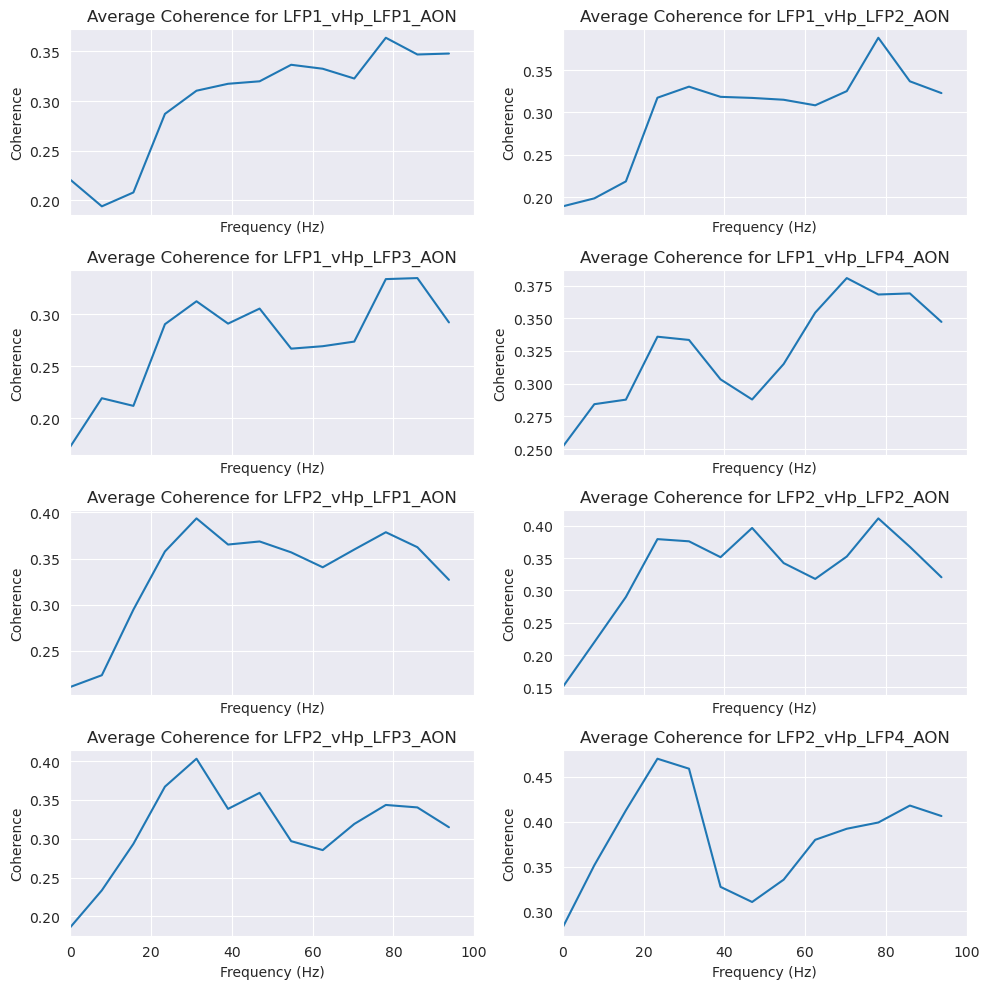

In [17]:
for window in windows['b_0']:
    start_idx = int(window[0] * fs)
    end_idx = int(window[1] * fs)
    spike_window_aon = df_aon.iloc[start_idx:end_idx]
    spike_window_vhp = df_vhp.iloc[start_idx:end_idx]

    # Loop through each pair of columns
    for col_aon, col_vhp in itertools.product(df_aon.columns, df_vhp.columns):
        f, Cxy = coherence(spike_window_aon[col_aon], spike_window_vhp[col_vhp], fs=fs)
        
        # Filter out frequencies above 100 Hz
        valid_idxs = np.where(f <= 100)[0]
        f_filtered = f[valid_idxs]
        Cxy_filtered = Cxy[valid_idxs]
        
        pair_key = f"{col_aon}_{col_vhp}"
        if pair_key not in coherence_sums:
            coherence_sums[pair_key] = np.zeros_like(Cxy_filtered)
            coherence_counts[pair_key] = 0

        coherence_sums[pair_key] += Cxy_filtered
        coherence_counts[pair_key] += 1

fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for idx, (pair_key, Cxy_sum) in enumerate(coherence_sums.items()):
    ax = axes[idx]  # Set the current axis
    Cxy_avg = Cxy_sum / coherence_counts[pair_key]
    
    ax.plot(f_filtered, Cxy_avg)
    ax.set_title(f'Average Coherence for {pair_key}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    ax.set_xlim(0, 100)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Plot the Data

In [ ]:
# Plot each channel ------------------------
num_channels = len(lfp.spikes.columns)
fig, axes = plt.subplots(num_channels, 1, figsize=(50, 40), sharex=True)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
first_4_seconds = int(4 * fs)
ticks = [0, int(1.0 * fs), int(2.0 * fs), int(3.0 * fs), int(4.0 * fs)]
labels = ['0', '1000', '2000', '3000', '4000']

for i, channel in enumerate(lfp.spikes.columns):
    ax = axes[i]
    ax.plot(lfp.spikes[channel][:first_4_seconds])
    ax.set_ylabel("Voltage (uV)")
    ax.set_title(channel)
    ax.grid(True)

In [ ]:
# Plot a 1 second window around each event ------------------------

new_ev = lfp.events[np.where(np.diff(lfp.events) > 2)[0]]
times = np.array(lfp.times["LFP1_AON"])
spikes = np.array(lfp.spikes["LFP1_AON"])
indices = np.rint(new_ev * fs).astype(int)
# Extract spike windows around these times
windows = []
for idx in indices:
    center_time = times[idx]
    
    # Calculate window start and end indices
    start_idx = max(idx - int(0 * fs), 0)
    end_idx = min(idx + int(1.0 * fs), len(spikes) - 1)
    
    # Extract spike window
    spike_window = spikes[start_idx:end_idx + 1]
    windows.append(spike_window)

n_pairs = len(windows) // 2
fig, axes = plt.subplots(n_pairs, 2, figsize=(20, 60), sharex=True)
x_ticks = [0, int(1.0 * fs)]
x_labels = ['0', '1000']

for i in range(n_pairs):
    ax1, ax2 = axes[i]
    ax1.plot(windows[2*i])
    ax2.plot(windows[2*i + 1])
    
    # Set the x-ticks and labels for each subplot
    for ax in [ax1, ax2]:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        
    ax1.set_xlim(0, len(windows[0]))
    ax2.set_xlim(0, len(windows[0]))
    ax1.set_ylabel("Voltage (uV)")
    ax2.set_ylabel("Voltage (uV)")
    ax1.set_xlabel("Time (ms)")
    ax2.set_xlabel("Time (ms)")
    ax1.grid(True)
    ax2.grid(True)
plt.show()

In [ ]:
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 100),
}

lfp.calculate_band_powers(bands)
logger.info(lfp.analysis_results)

In [ ]:
channel_pairs = list(itertools.combinations(lfp.spikes.columns, 2))
num_chan_pairs = len(channel_pairs)
fig, axes = plt.subplots(num_chan_pairs, 1, figsize=(20, 60), sharex=True)
plt.subplots_adjust(hspace=0.2)

for i, (chan1, chan2) in enumerate(channel_pairs):
    ax = axes[i]
    f, Cxy = lfp.get_coherence(lfp.spikes[chan1], lfp.spikes[chan2])

    # Limit frequencies to between 1 and 200
    mask = (f >= 1) & (f <= 200)
    f = f[mask]
    Cxy = Cxy[mask]

    ax.plot(f, Cxy)
    ax.set_title(f"{chan1} vs {chan2}")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Coherence")
    ax.set_xlim(1, 200)
    ax.grid(True)

plt.show()

In [ ]:
import random
import string
# Power spectrums
from scipy.signal import welch

freq_windows = windows[:7]
# Initialize a dictionary to hold FOOOF models for each channel
fooof_models = {}

for wind in freq_windows:
    random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    lfp_signal = wind
    
    # Compute the Power Spectral Density (PSD)
    frequencies, psd_values = welch(lfp_signal, fs=lfp.fs)
    
    # Slice frequencies and PSD values for 1-50Hz
    idx_start = np.where(frequencies >= 1)[0][0]
    idx_end = np.where(frequencies <= 200)[0][-1]
    frequencies = frequencies[idx_start:idx_end+1]
    psd_values = psd_values[idx_start:idx_end+1]

    # Calculate peak width limits
    peak_width_limits = [2 * (frequencies[1] - frequencies[0]), 16]  # Increased upper limit
    
    # Initialize FOOOF model
    fm = FOOOF(peak_width_limits=peak_width_limits)
    
    # Fit FOOOF model
    fm.fit(frequencies, psd_values)
    fooof_models[random_string] = fm
    
    # Plot
    fm.plot()

